# Daniele Sindaco 0001139535

# FRUIT INSPECTION

Students should develop a software system aimed at locating defects and imperfections on fruits. Each fruit is acquired 
through a NIR (Near Infra-Red) and a color camera with little parallax effect. 
The image name format is Cx_yyyyyy.bmp, where x is 0 for the NIR images and 1 for the color images, while yyyyyy is the 
incremental number of the pair. 

## SECOND TASK: RUSSET DETECTION

Images in folder “second task” show two apples with an unwanted reddish-brown area. <br>
Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits. <br>
HINT: Find a suitable (Mahalanobis) color distance. Other color spaces, e.g. HSV, HSL, LUV, should be tried. 

#### 1. Identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

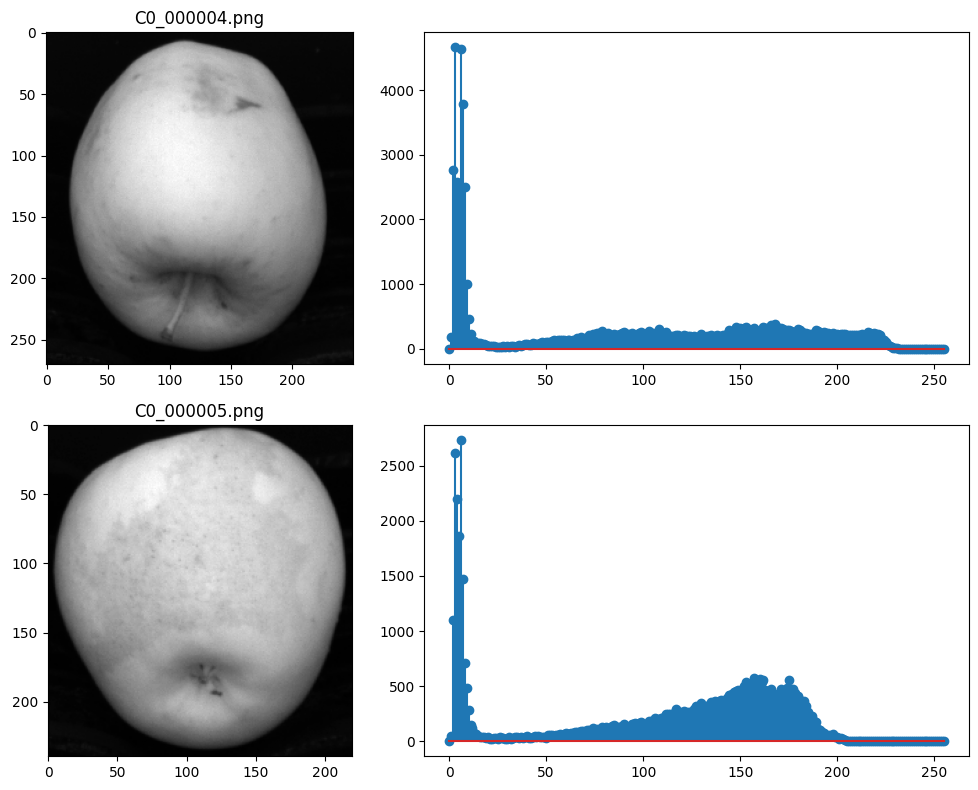

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 1.5]})

for i in range(2):
    path = f'./fruit-inspection-images/second task/C0_00000{i+4}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(img, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+4}.png")
    axs[i, 1].stem(hist)
    plt.tight_layout()

plt.show()    

We separate the foreground from background in order to compute the space color of fruit.

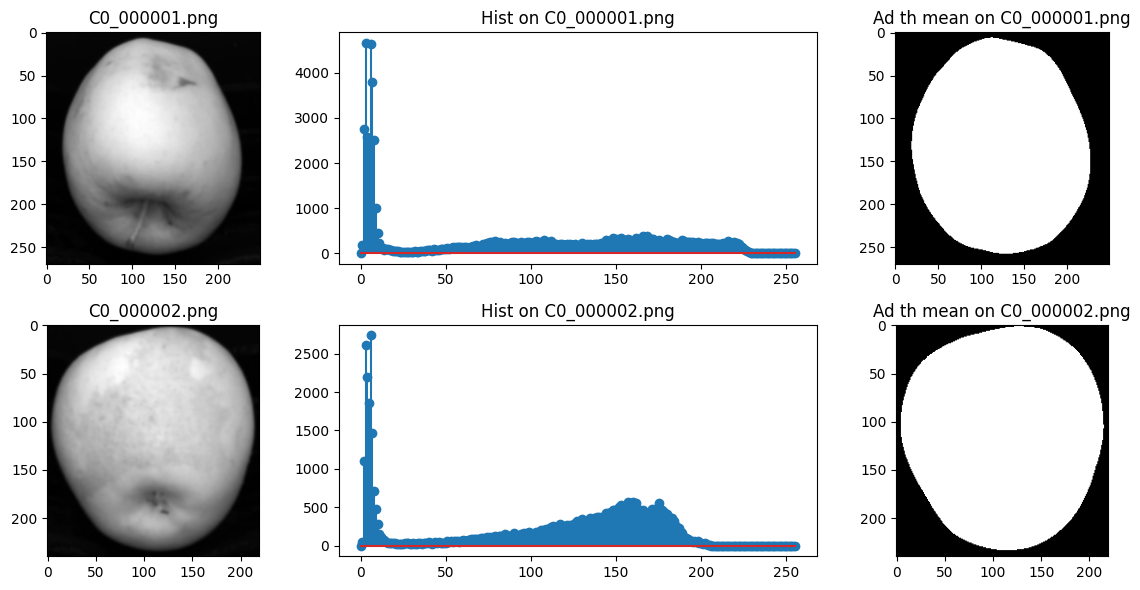

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.5, 1]})
th1_final_arr = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C0_00000{i+4}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    blur = cv2.bilateralFilter(img,5,75,75)
    th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,303,9)

    #fill background
    th1 = np.pad(th1, 1, mode='constant', constant_values=255)
    cv2.floodFill(th1, None, (0, 0), 0)
    th1 = th1[1:-1, 1:-1]

    #Flood-fill the background with 255 (white)
    th1_copy = th1.copy()
    h, w = img.shape
    mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(th1_copy, mask, (0,0), 255)

    #Fill internal holes by overlapping results
    th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))

    th1_final_arr.append(th1_final)

    hist, bins = np.histogram(img.flatten(), 256, [0,256])

    axs[i, 0].imshow(blur, cmap='gray'), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 2].imshow(th1_final, cmap='gray'), axs[i, 2].set_title(f"Ad th mean on C0_00000{i+1}.png")

    plt.tight_layout()

plt.show()    

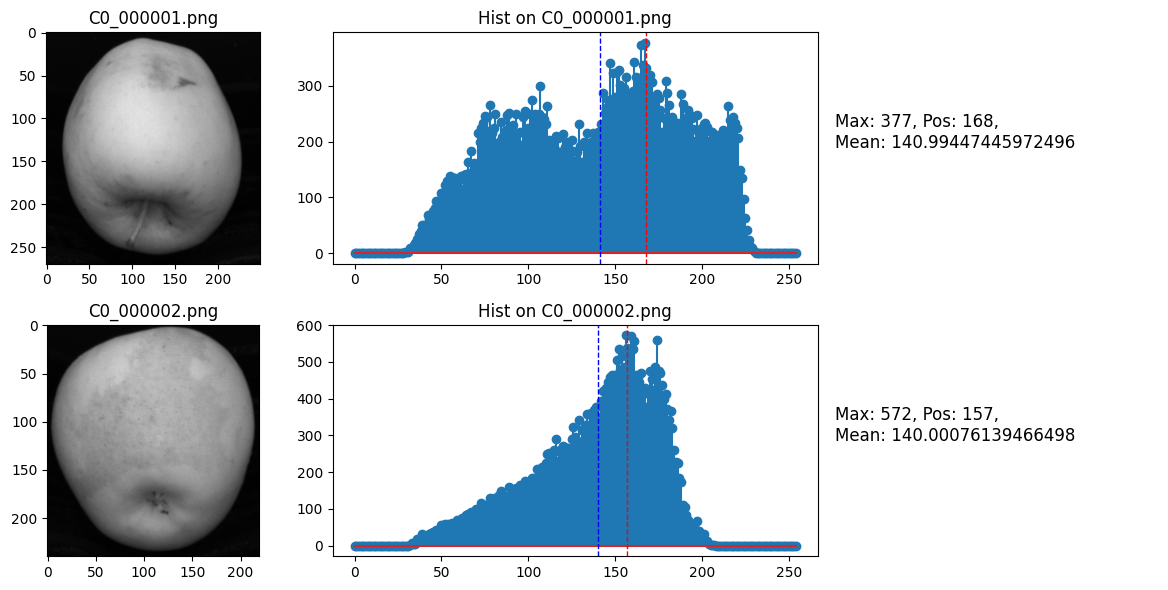

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.5, 1]})

for i in range(2):
    path = f'./fruit-inspection-images/second task/C0_00000{i+4}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    hist, bins = np.histogram(img[th1_final_arr[i] == 255].flatten(), 256, [0,256])

    pixels = img[th1_final_arr[i] == 255].reshape(-1, 1).astype(np.float32)
    covar_matrix, mean_color = cv2.calcCovarMatrix(pixels, None, flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE)

    axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].stem(hist[1:]), axs[i, 1].set_title(f"Hist on C0_00000{i+1}.png")
    axs[i, 1].axvline(x=np.where(hist == np.max(hist[1:]))[0], color='r', linestyle='--', linewidth=1)
    axs[i, 1].axvline(x=mean_color, color='b', linestyle='--', linewidth=1)
    axs[i, 2].text(0, 0.5, 
                   f"Max: {np.max(hist[1:])}, Pos: {np.where(hist == np.max(hist[1:]))[0][0]}, \nMean: {mean_color[0][0]}", 
                   fontsize=12), axs[i, 2].axis('off')
    
    plt.tight_layout()

plt.show()    

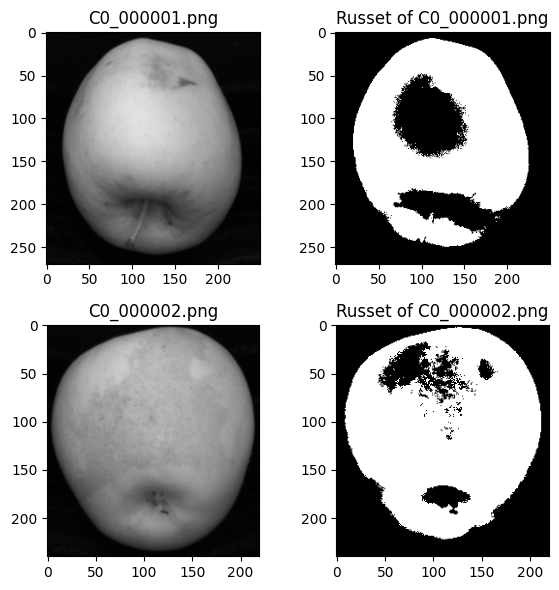

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1]})
russets = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C0_00000{i+4}.png'
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Suppose fruit_only is a 1D array of grayscale pixels (float32 or float64)
    fruit_pixels = img[th1_final_arr[i] == 255].astype(np.float64).reshape(-1, 1)
    
    covar_matrix, mean_color = cv2.calcCovarMatrix(
        fruit_pixels,
        None,
        flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
    )
    
    # Convert outputs to proper scalars
    mean_val = np.float64(mean_color[0, 0])
    inv_cov = np.float64(1.0 / covar_matrix[0, 0])
    
    # Initialize mask
    russet_mask = np.zeros_like(img, dtype=np.uint8)
    
    # Loop through pixels
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                # Prepare inputs as 1D arrays (OpenCV expects same dtype & shape)
                pixel_val = np.float64([img[x, y]])
                mean_vec = np.float64([mean_val])
                inv_cov_mat = np.float64([[inv_cov]])
    
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov_mat)
    
                if mahal_dist < 1.2:
                    russet_mask[x, y] = 255


    russets.append(russet_mask)

    axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Russet of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

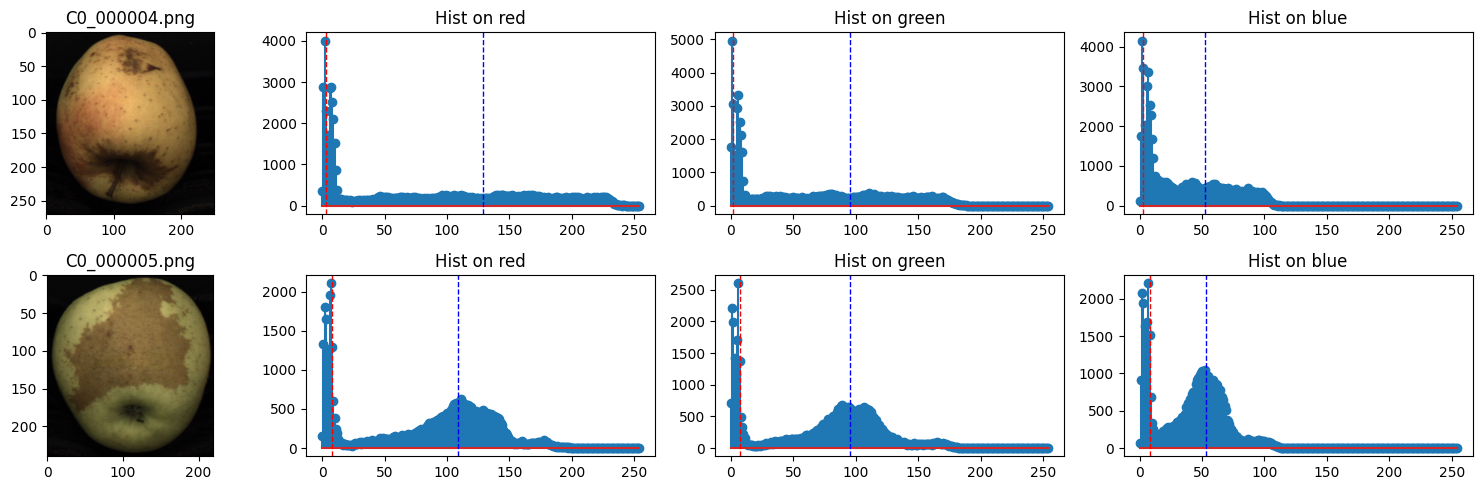

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.5, 1.5, 1.5]})

for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[i, 0].imshow(img), axs[i, 0].set_title(f"C0_00000{i+4}.png")
    for j in range(img.shape[2]):
        pixels = img[:,:,j][th1_final_arr[i] == 255].reshape(-1, 1).astype(np.float32)
        covar_matrix, mean_color = cv2.calcCovarMatrix(pixels, None, flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE)
        
        hist, bins = np.histogram(img[:,:,j].flatten(), 256, [0,256])
        axs[i, j+1].stem(hist[1:])
        axs[i, j+1].axvline(x=np.where(hist == np.max(hist[1:]))[0], color='r', linestyle='--', linewidth=1)
        axs[i, j+1].axvline(x=mean_color, color='b', linestyle='--', linewidth=1)
        axs[i, j+1].set_title("Hist on red" if j == 0 else "Hist on green" if j == 1 else "Hist on blue")
        
    plt.tight_layout()

plt.show()    

We try to compute the mean of the image's color and then for every pixel we compute the Mahalanobis distance. This solution doesn't work.

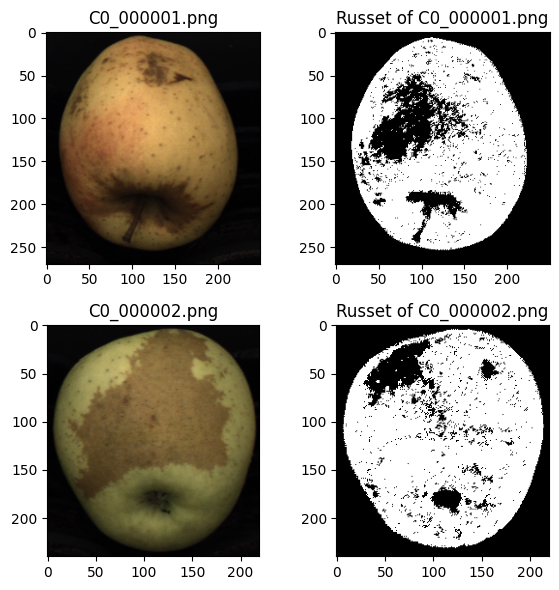

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1]})
russets = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract masked pixels (each row = pixel vector)
    fruit_pixels = img[th1_final_arr[i] == 255].astype(np.float64)
    
    # Make sure it’s 2D (N x D)
    if fruit_pixels.ndim == 1:
        fruit_pixels = fruit_pixels.reshape(-1, 1)
    
    # Compute covariance and mean
    covar_matrix, mean_color = cv2.calcCovarMatrix(
        fruit_pixels,
        None,
        flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
    )
    
    # Invert covariance
    _, inv_cov = cv2.invert(covar_matrix)
    
    # Ensure both are 1D float64 arrays
    mean_vec = mean_color.flatten().astype(np.float64)
    
    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = img[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist < 2:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Russet of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

We try also to change color space. This solution doesn't work.

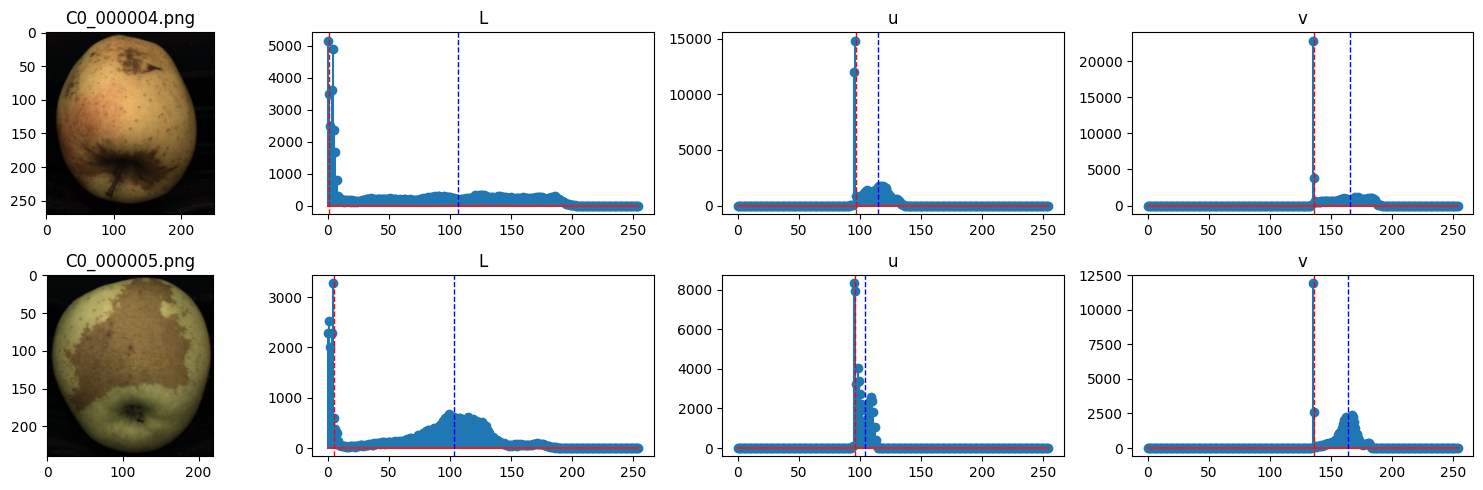

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.5, 1.5, 1.5]})

for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_Luv2RGB)), axs[i, 0].set_title(f"C0_00000{i+4}.png")
    for j in range(img.shape[2]):
        pixels = img[:,:,j][th1_final_arr[i] == 255].reshape(-1, 1).astype(np.float32)
        covar_matrix, mean_color = cv2.calcCovarMatrix(pixels, None, flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE)
        
        hist, bins = np.histogram(img[:,:,j].flatten(), 256, [0,256])
        axs[i, j+1].stem(hist[1:])
        axs[i, j+1].axvline(x=np.where(hist == np.max(hist[1:]))[0], color='r', linestyle='--', linewidth=1)
        axs[i, j+1].axvline(x=mean_color, color='b', linestyle='--', linewidth=1)
        axs[i, j+1].set_title("L" if j == 0 else "u" if j == 1 else "v")
        
    plt.tight_layout()

plt.show()    

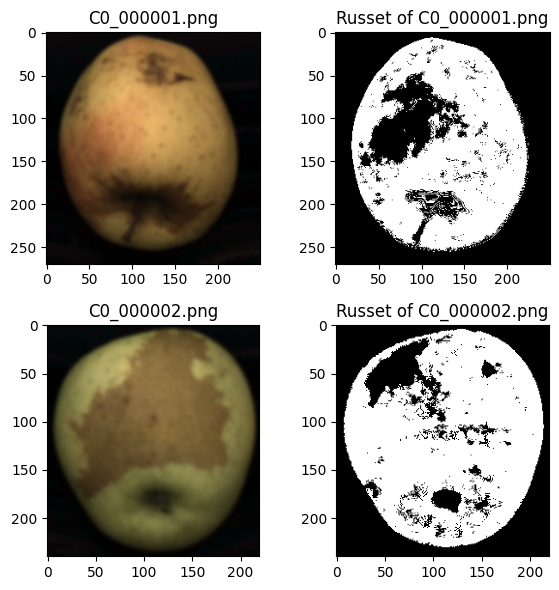

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1]})
russets = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    # Extract masked pixels (each row = pixel vector)
    fruit_pixels = img[th1_final_arr[i] == 255].astype(np.float64)
    
    # Make sure it’s 2D (N x D)
    if fruit_pixels.ndim == 1:
        fruit_pixels = fruit_pixels.reshape(-1, 1)
    
    # Compute covariance and mean
    covar_matrix, mean_color = cv2.calcCovarMatrix(
        fruit_pixels,
        None,
        flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
    )
    
    # Invert covariance
    _, inv_cov = cv2.invert(covar_matrix)
    
    # Ensure both are 1D float64 arrays
    mean_vec = mean_color.flatten().astype(np.float64)
    
    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = img[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist < 2:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Russet of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

Another solution is to take an image of the first folder with no russet on the apple, compute the mean and the covariance matrix and the use them to compute the mahalanobis distance on the pixels of the second task images. This solution doesn't work.

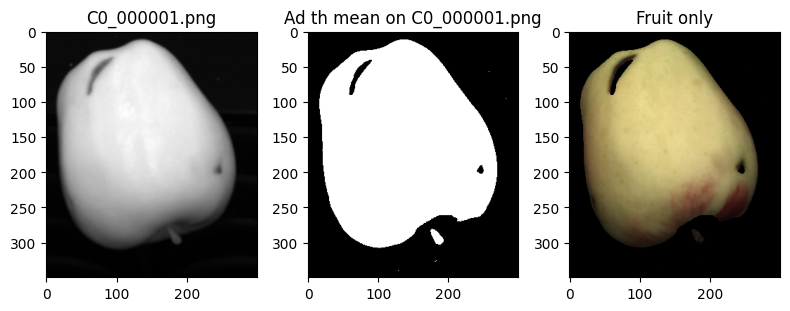

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(8, 8), gridspec_kw={'width_ratios': [1, 1, 1]})

path = f'./fruit-inspection-images/first task/C0_000001.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

path = f'./fruit-inspection-images/first task/C1_000001.png'
img_colored = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

blur = cv2.bilateralFilter(img,5,75,75)
th1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,101,9)

#fill background
th1 = np.pad(th1, 1, mode='constant', constant_values=255)
cv2.floodFill(th1, None, (0, 0), 0)
th1 = th1[1:-1, 1:-1]

#Flood-fill the background with 255 (white)
th1_copy = th1.copy()
h, w = img.shape
mask = np.zeros((h+2, w+2), dtype=np.uint8)
cv2.floodFill(th1_copy, mask, (0,0), 255)

#Fill internal holes by overlapping results
#th1_final = np.maximum(th1, cv2.bitwise_not(th1_copy))
fruit_only = cv2.bitwise_and(img_colored, img_colored, mask=th1)

axs[0].imshow(blur, cmap='gray'), axs[0].set_title(f"C0_000001.png")
axs[1].imshow(th1, cmap='gray'), axs[1].set_title(f"Ad th mean on C0_000001.png")
#axs[2].imshow(cv2.cvtColor(fruit_only, cv2.COLOR_Luv2RGB)), axs[2].set_title(f"Fruit only")
axs[2].imshow(fruit_only), axs[2].set_title(f"Fruit only")

plt.tight_layout()

plt.show()    

In [16]:
fruit_pixels = img_colored[th1 == 255].astype(np.float64)
    
# Make sure it’s 2D (N x D)
if fruit_pixels.ndim == 1:
    fruit_pixels = fruit_pixels.reshape(-1, 1)

print(fruit_pixels.shape)

# Compute covariance and mean
covar_matrix, mean_color = cv2.calcCovarMatrix(
    fruit_pixels,
    None,
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)

# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

print(covar_matrix)
print(mean_color)
print(inv_cov)
print(mean_vec)

(55470, 3)
[[3291.09250845 3272.48403493 2152.90949534]
 [3272.48403493 3301.18523401 2160.51439049]
 [2152.90949534 2160.51439049 1430.20777458]]
[[162.49899045 146.55210023  94.02154318]]
[[ 0.02540829 -0.01372932 -0.01750748]
 [-0.01372932  0.03412234 -0.03087931]
 [-0.01750748 -0.03087931  0.07370063]]
[162.49899045 146.55210023  94.02154318]


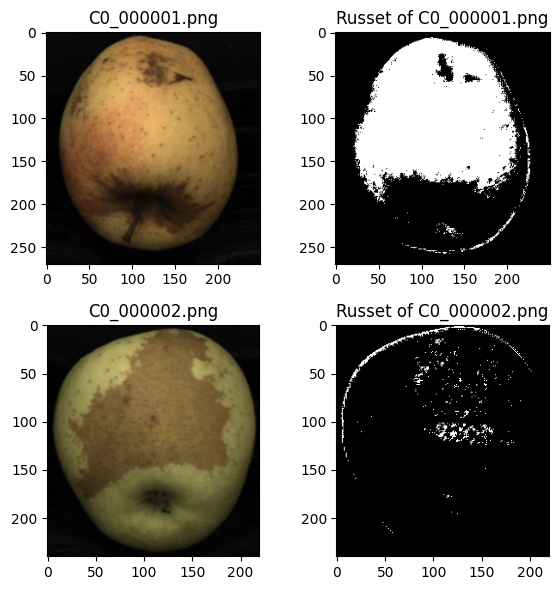

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1]})
russets = []

for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = img[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist > 4:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Russet of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

Last solution, use reference images of part of apples without russet. Then compute mahalanobis distance.

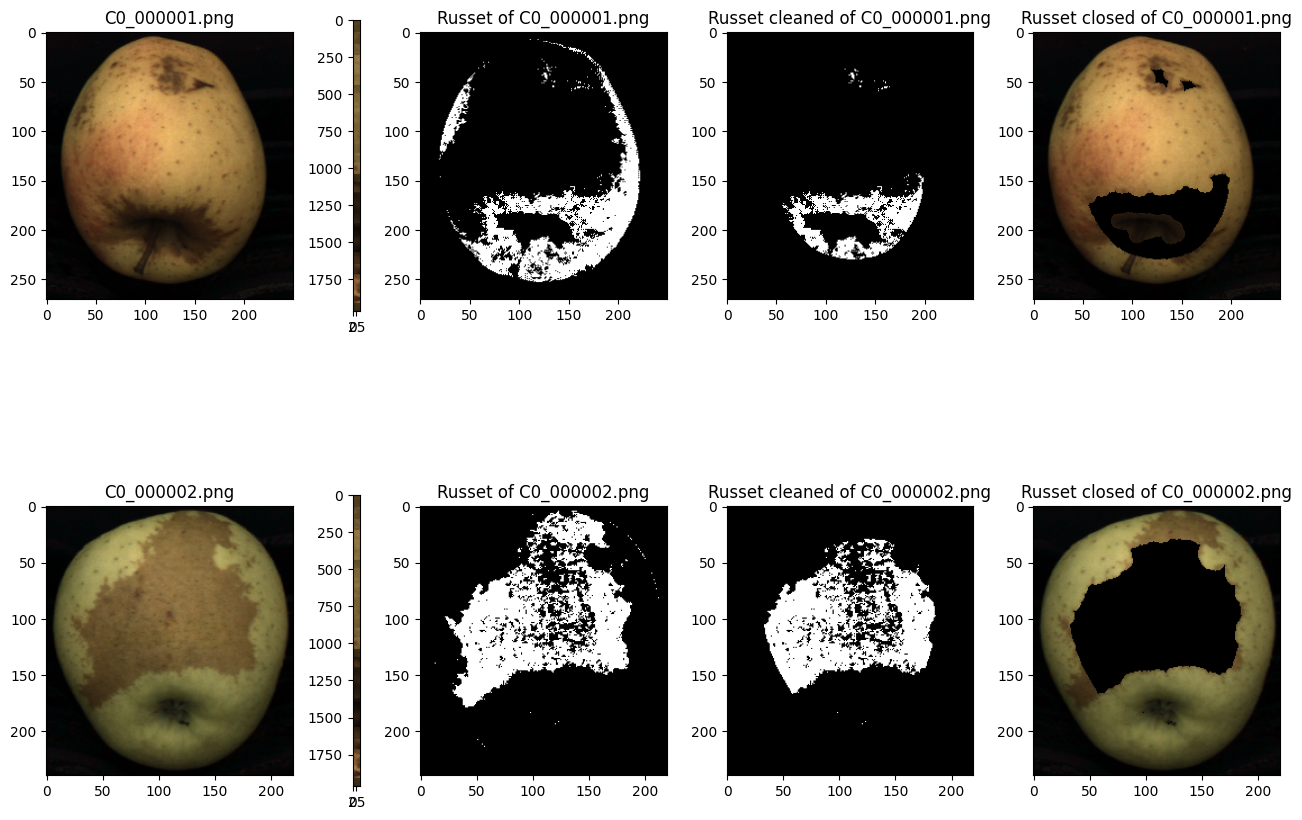

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(13, 13), gridspec_kw={'width_ratios': [1, 0.03, 1, 1, 1]})
russets = []
russets_cleaned = []
final_russets = []
russets_rgb = []

ref = []

"""for i in range(2):
    for j in range(11):
        path = f'./fruit-inspection-images/second task/reference/C1_00000{i+4}_{j}.png'
        img = cv2.imread(path)
        img = cv2.GaussianBlur(img,(9,9),0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

        ref.append(img)"""

for i in range(29):
    path = f'./fruit-inspection-images/second task/samples/sample_{i+1:02d}.png'
    img = cv2.imread(path)
    img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    ref.append(img)

# Trova la larghezza minima tra tutte le immagini
w_min = min(img.shape[1] for img in ref)

# Inizializza la matrice dei campioni con una riga vuota come placeholder
sample_matrix = np.zeros((1, w_min, 3), dtype=np.uint8)

# Costruisci la matrice dei campioni suddividendo e concatenando le immagini
for img in ref:
    width = img.shape[1]  # Larghezza dell'immagine
    n_subsamples = width // w_min  # Numero di sotto-campioni possibili
    
    # Estrai e concatena sotto-campioni di larghezza w_min
    for j in range(0, n_subsamples * w_min, w_min):
        sub_sample = img[:, j:j+w_min, :]  # Sotto-campione
        sample_matrix = np.concatenate((sample_matrix, sub_sample), axis=0)

# Rimuovi la riga iniziale (placeholder)
sample_matrix = sample_matrix[1:, :, :]

# Estrai solo i canali U e V e ridimensiona in una matrice Nx2 così da avere solo celle contenenti i valori u e v.
uv_data = sample_matrix[:, :, 1:3].reshape(-1, 2)
#sample_matrix = sample_matrix[:, :, :].reshape(-1, 3)
#print(sample_matrix.shape)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    uv_data, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
    
# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

for i in range(2):    
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = img[x, y, 1:3].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist < 1.27:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    # Calcola lo sfondo invertendo la segmentazione manuale
    background = 255 - th1_final_arr[i]

    # Dilata lo sfondo per creare un bordo attorno ad esso
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    dilated_bg = cv2.dilate(background, kernel, iterations=4)

    # Sottrai lo sfondo dilatato dalla maschera originale dei russet
    russet_cleaned = cv2.subtract(russets[i], dilated_bg)
    russets_cleaned.append(russet_cleaned)

    # Definisci l'elemento strutturante per l'operazione di chiusura
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    
    # Chiudi eventuali piccoli buchi nella maschera usando MORPH_CLOSE
    closed_russet = cv2.morphologyEx(russet_cleaned, cv2.MORPH_CLOSE, structuring_element)
    final_russets.append(closed_russet)
    
    # Applica la maschera binaria all'immagine RGB originale
    #russets_rgb = highlight_edges(img, final_russets)

    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(cv2.cvtColor(sample_matrix, cv2.COLOR_Luv2RGB)), axs[i, 2].set_title(f"Samples")
    axs[i, 2].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Russet of C0_00000{i+1}.png")
    axs[i, 3].imshow(russet_cleaned, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Russet cleaned of C0_00000{i+1}.png")
    axs[i, 4].imshow(cv2.bitwise_and(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cv2.cvtColor(img, cv2.COLOR_Luv2RGB), mask=cv2.bitwise_not(closed_russet)), cmap='gray', vmin=0, vmax=255), axs[i, 4].set_title(f"Russet closed of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

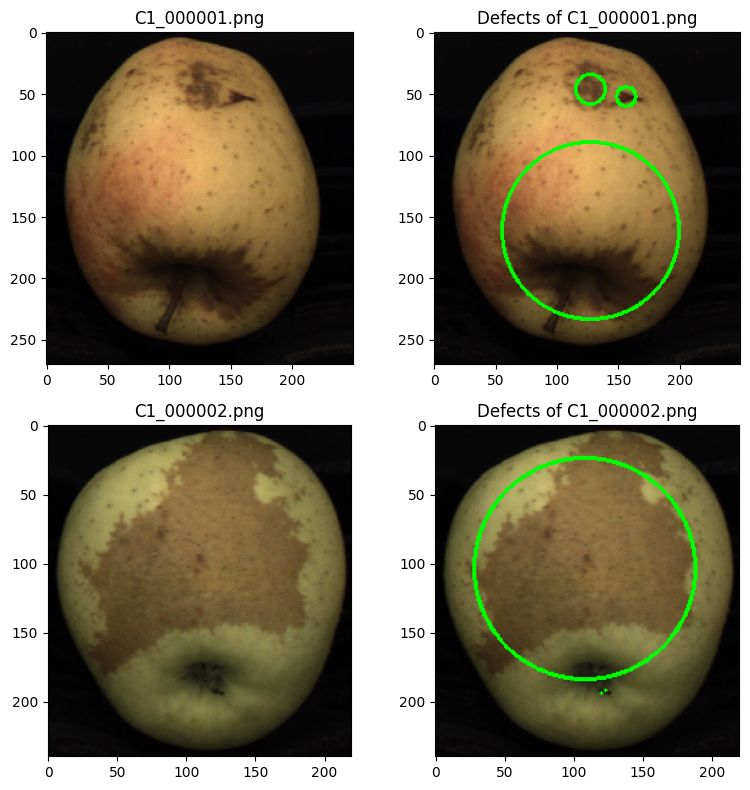

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [1, 1]})
for i in range(2):
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #defects = cv2.bitwise_and(image_rgb, image_rgb, mask=cv2.bitwise_not(int_edge_dil_arr[i]))
    defects = image_rgb.copy()

    contours, _ = cv2.findContours(final_russets[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (center_x, center_y), radius = cv2.minEnclosingCircle(contour)
        center = (int(center_x), int(center_y))
        radius = int(radius)
        # Draw on image
        cv2.circle(defects, center, radius, (0, 255, 0), 2)

    #Print images
    axs[i, 0].imshow(image_rgb), axs[i, 0].set_title(f"C1_00000{i+1}.png")
    axs[i, 1].imshow(defects), axs[i, 1].set_title(f"Defects of C1_00000{i+1}.png")

    plt.tight_layout()

ALTRE PROVE:

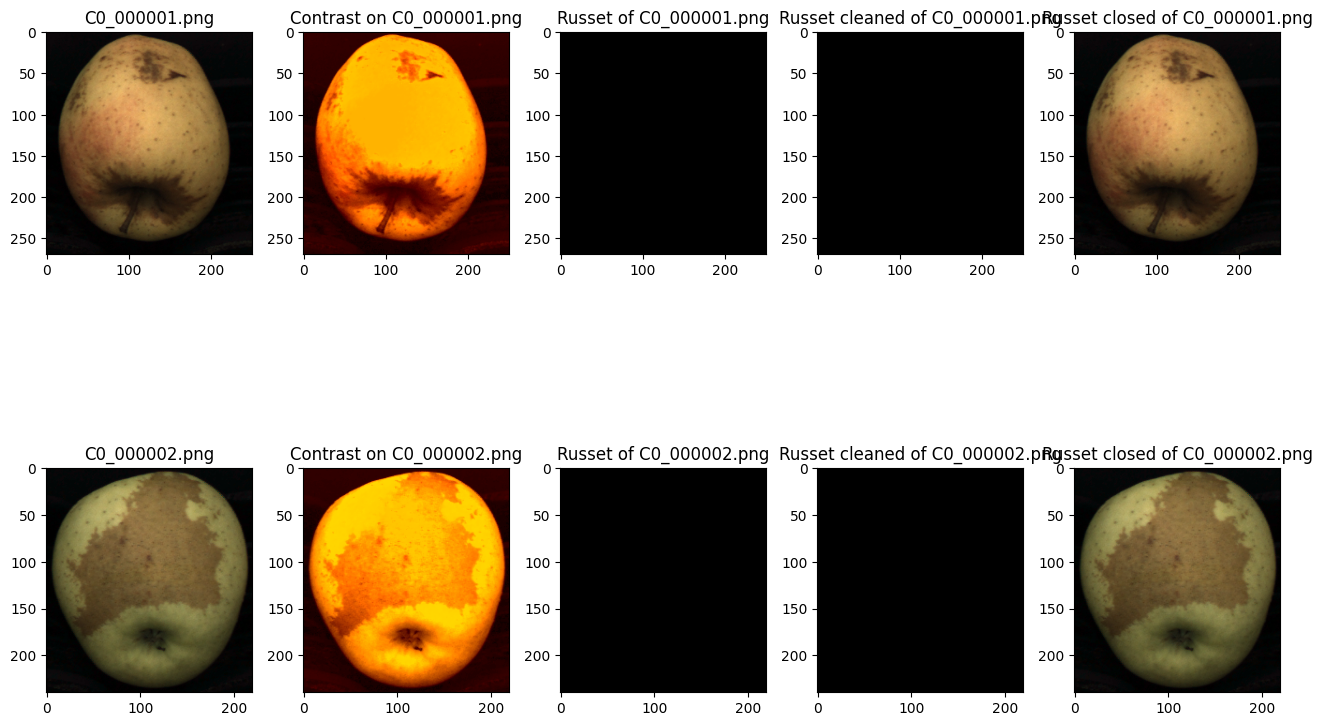

In [28]:
fig, axs = plt.subplots(2, 5, figsize=(13, 13), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})
russets = []
russets_cleaned = []
final_russets = []
russets_rgb = []

ref = []

alpha = 2.0
beta = 2

for i in range(13):
    path = f'./fruit-inspection-images/second task/reference/ref{i+1}.png'
    img = cv2.imread(path)
    img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    ref.append(new_img)



# Trova la larghezza minima tra tutte le immagini
w_min = min(img.shape[1] for img in ref)

# Inizializza la matrice dei campioni con una riga vuota come placeholder
sample_matrix = np.zeros((1, w_min, 3), dtype=np.uint8)

# Costruisci la matrice dei campioni suddividendo e concatenando le immagini
for img in ref:
    width = img.shape[1]  # Larghezza dell'immagine
    n_subsamples = width // w_min  # Numero di sotto-campioni possibili
    
    # Estrai e concatena sotto-campioni di larghezza w_min
    for j in range(0, n_subsamples * w_min, w_min):
        sub_sample = img[:, j:j+w_min, :]  # Sotto-campione
        sample_matrix = np.concatenate((sample_matrix, sub_sample), axis=0)

# Rimuovi la riga iniziale (placeholder)
sample_matrix = sample_matrix[1:, :, :]

# Estrai solo i canali U e V e ridimensiona in una matrice Nx2 così da avere solo celle contenenti i valori u e v.
#uv_data = sample_matrix[:, :, 1:3].reshape(-1, 2)
sample_matrix = sample_matrix[:, :, :].reshape(-1, 3)
#print(sample_matrix.shape)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    sample_matrix, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
    
# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

for i in range(2):    
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

    new_img = np.zeros(img.shape, img.dtype)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = img[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist > 3:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    # Calcola lo sfondo invertendo la segmentazione manuale
    background = 255 - th1_final_arr[i]

    # Dilata lo sfondo per creare un bordo attorno ad esso
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_bg = cv2.dilate(background, kernel, iterations=4)

    # Sottrai lo sfondo dilatato dalla maschera originale dei russet
    russet_cleaned = cv2.subtract(russets[i], dilated_bg)
    russets_cleaned.append(russet_cleaned)

    # Definisci l'elemento strutturante per l'operazione di chiusura
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    
    # Chiudi eventuali piccoli buchi nella maschera usando MORPH_CLOSE
    closed_russet = cv2.morphologyEx(russet_mask, cv2.MORPH_CLOSE, structuring_element)
    final_russets.append(closed_russet)
    
    # Applica la maschera binaria all'immagine HSV originale
    #russets_rgb = highlight_edges(img, final_russets)

    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(cv2.cvtColor(new_img, cv2.COLOR_Luv2RGB), cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Contrast on C0_00000{i+1}.png")
    #axs[i, 1].imshow(cv2.cvtColor(sample_matrix, cv2.COLOR_Luv2RGB)), axs[i, 2].set_title(f"Samples")
    axs[i, 2].imshow(russet_mask, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Russet of C0_00000{i+1}.png")
    axs[i, 3].imshow(russet_cleaned, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Russet cleaned of C0_00000{i+1}.png")
    axs[i, 4].imshow(cv2.bitwise_and(cv2.cvtColor(img, cv2.COLOR_Luv2RGB), cv2.cvtColor(img, cv2.COLOR_Luv2RGB), mask=cv2.bitwise_not(closed_russet)), cmap='gray', vmin=0, vmax=255), axs[i, 4].set_title(f"Russet closed of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

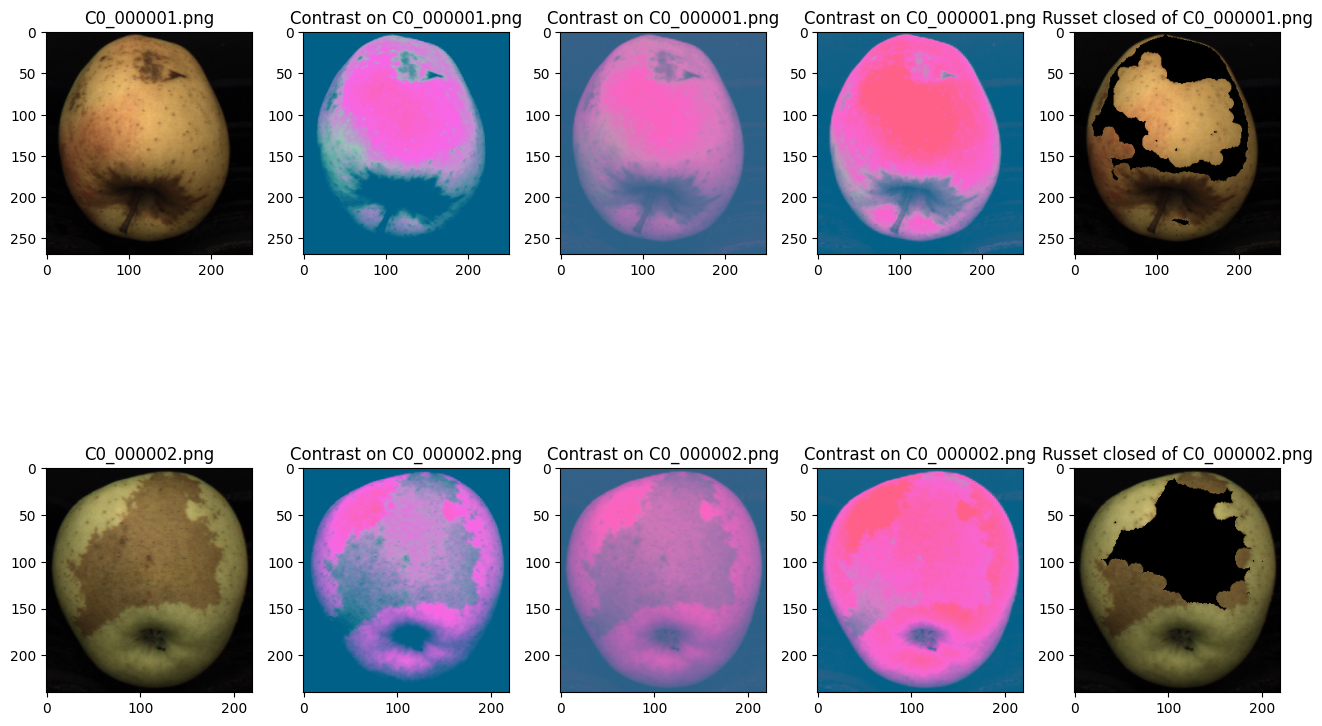

In [52]:
fig, axs = plt.subplots(2, 5, figsize=(13, 13), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})
russets = []
russets_cleaned = []
final_russets = []
russets_rgb = []

ref = []

for i in range(13):
    alpha = 3.0
    beta = -150    
    path = f'./fruit-inspection-images/second task/reference/ref{i+1}.png'
    img = cv2.imread(path)

    img1 = np.zeros(img.shape, img.dtype)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                img1[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
    img1 = cv2.GaussianBlur(img1,(9,9),0)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Luv)

    ref.append(img1)

# Trova la larghezza minima tra tutte le immagini
w_min = min(img.shape[1] for img in ref)

# Inizializza la matrice dei campioni con una riga vuota come placeholder
sample_matrix = np.zeros((1, w_min, 3), dtype=np.uint8)

# Costruisci la matrice dei campioni suddividendo e concatenando le immagini
for img in ref:
    width = img.shape[1]  # Larghezza dell'immagine
    n_subsamples = width // w_min  # Numero di sotto-campioni possibili
    
    # Estrai e concatena sotto-campioni di larghezza w_min
    for j in range(0, n_subsamples * w_min, w_min):
        sub_sample = img[:, j:j+w_min, :]  # Sotto-campione
        sample_matrix = np.concatenate((sample_matrix, sub_sample), axis=0)

# Rimuovi la riga iniziale (placeholder)
sample_matrix = sample_matrix[1:, :, :]

# Estrai solo i canali U e V e ridimensiona in una matrice Nx2 così da avere solo celle contenenti i valori u e v.
#uv_data = sample_matrix[:, :, 1:3].reshape(-1, 2)
sample_matrix = sample_matrix[:, :, :].reshape(-1, 3)
#print(sample_matrix.shape)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    sample_matrix, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)
    
# Invert covariance
_, inv_cov = cv2.invert(covar_matrix)

# Ensure both are 1D float64 arrays
mean_vec = mean_color.flatten().astype(np.float64)

for i in range(2):    
    alpha = 3.0
    beta = -150
    path = f'./fruit-inspection-images/second task/C1_00000{i+4}.png'
    img = cv2.imread(path)
    #img = cv2.GaussianBlur(img,(9,9),0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    new_img1 = np.zeros(img.shape, img.dtype)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img1[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    new_img2 = np.zeros(img.shape, img.dtype)
    alpha = 1.3
    beta = 40

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img2[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    new_img3 = np.zeros(img.shape, img.dtype)
    alpha = 3
    beta = 0

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_img3[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img1 = cv2.cvtColor(new_img1, cv2.COLOR_BGR2Luv)
    new_img2 = cv2.cvtColor(new_img2, cv2.COLOR_BGR2Luv)
    new_img3 = cv2.cvtColor(new_img3, cv2.COLOR_BGR2Luv)
    
    # Loop through pixels
    russet_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if th1_final_arr[i][x, y] == 255:
                pixel_val = new_img1[x, y, :].astype(np.float64).flatten()
                mahal_dist = cv2.Mahalanobis(pixel_val, mean_vec, inv_cov)
                
                if mahal_dist < 1:
                    russet_mask[x, y] = 255

    russets.append(russet_mask)

    # Calcola lo sfondo invertendo la segmentazione manuale
    background = 255 - th1_final_arr[i]

    # Dilata lo sfondo per creare un bordo attorno ad esso
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_bg = cv2.dilate(background, kernel, iterations=4)

    # Sottrai lo sfondo dilatato dalla maschera originale dei russet
    russet_cleaned = cv2.subtract(russets[i], dilated_bg)
    russets_cleaned.append(russet_cleaned)

    # Definisci l'elemento strutturante per l'operazione di chiusura
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    
    # Chiudi eventuali piccoli buchi nella maschera usando MORPH_CLOSE
    closed_russet = cv2.morphologyEx(russet_mask, cv2.MORPH_CLOSE, structuring_element)
    final_russets.append(closed_russet)
    
    # Applica la maschera binaria all'immagine HSV originale
    #russets_rgb = highlight_edges(img, final_russets)

    axs[i, 0].imshow(img, cmap='gray', vmin=0, vmax=255), axs[i, 0].set_title(f"C0_00000{i+1}.png")
    axs[i, 1].imshow(new_img1, cmap='gray', vmin=0, vmax=255), axs[i, 1].set_title(f"Contrast on C0_00000{i+1}.png")
    #axs[i, 1].imshow(cv2.cvtColor(sample_matrix, cv2.COLOR_Luv2RGB)), axs[i, 2].set_title(f"Samples")
    axs[i, 2].imshow(new_img2, cmap='gray', vmin=0, vmax=255), axs[i, 2].set_title(f"Contrast on C0_00000{i+1}.png")
    axs[i, 3].imshow(new_img3, cmap='gray', vmin=0, vmax=255), axs[i, 3].set_title(f"Contrast on C0_00000{i+1}.png")
    axs[i, 4].imshow(cv2.bitwise_and(img, img, mask=cv2.bitwise_not(closed_russet)), cmap='gray', vmin=0, vmax=255), axs[i, 4].set_title(f"Russet closed of C0_00000{i+1}.png")
    
    plt.tight_layout()

plt.show()    

In [109]:
path = f'./fruit-inspection-images/second task/C1_000004.png'
img = cv2.imread(path)
#img = cv2.GaussianBlur(img,(9,9),0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Extract masked pixels (each row = pixel vector)
fruit_pixels = img[th1_final_arr[0] == 255].astype(np.float64)

# Make sure it’s 2D (N x D)
if fruit_pixels.ndim == 1:
    fruit_pixels = fruit_pixels.reshape(-1, 1)

# Calcola la matrice di covarianza e il vettore del color medio
covar_matrix, mean_color = cv2.calcCovarMatrix(
    fruit_pixels, 
    None, 
    flags=cv2.COVAR_ROWS | cv2.COVAR_NORMAL | cv2.COVAR_SCALE
)

print(np.mean(mean_color))

92.12503274394237
